# Assignment 1 - Data Curation
Sean Miller (<millsea0@u.washington.edu>)


#### Overview

This notebook outlines using the Wikipedia **Pagecounts** and **Pageviews APIs** to analyze data about the amount of traffic both the desktop and mobile English Wikipedia sites saw per month from January 2008 through September 2017.

#### Libraries

All of the following code was written and tested against the default packages present in **Anaconda3 v4.4.0**. You can find a download for Anaconda and its latest versions at <https://repo.continuum.io/archive/>.

In [1]:
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import os
import pandas as pd
import requests
from urllib.parse import urljoin
%matplotlib inline

First, we need to construct URLs we'll be sending RESTful requests to for each API. We can use the following references to construct the URLs.

|API | Documentation | Endpoint | Date Range |
|--------------------------------|
|Pagecounts | [Pagecounts Documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts) | [RESTBase Reference](https://wikimedia.org/api/rest_v1/)| Jan 2008 - July 2016 |
|Pageviews | [Pageview Documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews) | [RESTBase Reference](https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end)| July 2015 - Present Day |

In [2]:
# Both endpoints share the same base URL
root_endpoint = "https://wikimedia.org/api/rest_v1/metrics/"
pagecount_url = "legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}"
pageviews_url = "pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}"

# Create the Pagecounts API format string
pagecount_endpoint = urljoin(root_endpoint, pagecount_url)

# Create the Pageviews API format string
pageviews_endpoint = urljoin(root_endpoint, pageviews_url)

For this analysis, we're only interested in capturing statistics for complete months. The expected format of a date string in either API is YYYYMMDDHH where YYYY is year, MM is the month, DD is the day and HH is the hour.

In [3]:
# Pagecounts API date range extends through entire date range specified above
pagecounts_dates = {"date_start": "2008010100", "date_end": "2016073100"}

# Pageviews API date range only includes whole months so we end in September 2017
pageviews_dates = {"date_start": "2015070100", "date_end": "2017093000"}
dates_dict = {"pagecounts": pagecounts_dates, "pageviews": pageviews_dates}

To break out our result sets into desktop and mobile groupings, we need to specify access-site in the Pagecounts API and access in the Pageviews API. In the Pageviews API, mobile views can come from both the mobile website and the mobile application.

As part of the Terms and conditions from the [Wikimedia REST API](https://www.mediawiki.org/wiki/REST_API), we agree to send a unique User-Agent header in our requests so Wikimedia can contact us if any problem arises from our script.

In [4]:
# Create Access-site/Access dictionary
pagecount_access_site = ["desktop-site", "mobile-site"]
pageviews_access = ["desktop", "mobile-web", "mobile-app"]
access_dict = {"pagecounts": pagecount_access_site, "pageviews": pageviews_access}

# Create user-agent header
headers = {"User-Agent" : "https://github.com/awfuldynne", "From" : "millsea0@uw.edu"}
response_results = {}

Looping through the Access-Site values for the **Pagecounts API** and the Access values for the **Pageviews API**, we store off the JSON reposnse from the API into the object response_results which is a dictionary that maps Access-Site/Access values to the response dictionary.

Part of the improvements in the **Pageviews API** is the ability to filter down to only users and not web crawlers hitting Wikipedia sites. Because we're primarily interested in user and not crawler traffic, we set the agent field for our requests to Pageviews.

In [5]:
# Loop through each access-site and store the response in response_results
for access_site in pagecount_access_site:
    pagecount_params = \
        {
            "project": "en.wikipedia.org",
            "access-site": access_site,
            "granularity": "monthly",
            "start": pagecounts_dates["date_start"],
            "end": pagecounts_dates["date_end"]
        }

    api_call = requests.get(pagecount_endpoint.format(**pagecount_params), headers=headers)
    response = api_call.json()
    response_results[access_site] = response

In [6]:
# Loop through each access and store the response in response_results
for access in pageviews_access:
    pageviews_params = \
        {
            "project": "en.wikipedia.org",
            "access": access,
            # For the Pageviews API, we filter down to only user agent hits to avoid web crawler page views
            "agent": "user",
            "granularity": "monthly",
            "start": pageviews_dates["date_start"],
            "end": pageviews_dates["date_end"]
        }

    api_call = requests.get(pageviews_endpoint.format(**pageviews_params), headers=headers)
    response = api_call.json()
    response_results[access] = response

In the case that the **Wikimedia APIs** ever go down, we write out the JSON responses we've received from the API. The data within this GitHub repo was retrieved from the respective APIs on 10/16/2017.

In [8]:
# If the folder raw_data doesn't already exist, create it
if not os.path.exists("raw_data"):
    os.makedirs("./raw_data")

# Loop through each api in access dictionary
for api in access_dict.keys():
    # Loop through each access-site/access type
    for access in access_dict[api]:
        # Write out a file for each JSON reponse to the raw_data folder
        outfile = open("./raw_data/{}_{}_{}-{}.json"
                       .format(api,
                               access,
                               dates_dict[api]["date_start"][:6],
                               dates_dict[api]["date_end"][:6]), "w")
        outfile.write(str(response_results[access]))
        outfile.close()

Now that we have our responses from the APIs, we'll transform each item in each response into a data point of the form (Year, Month, API, Access-Site/Access, Views/Counts).

###### Example Pagecounts Item:

In [9]:
response_results["mobile-site"]["items"][0]

{'access-site': 'mobile-site',
 'count': 3091546685,
 'granularity': 'monthly',
 'project': 'en.wikipedia',
 'timestamp': '2014100100'}

###### Example Pageviews Item:

In [10]:
response_results["mobile-app"]["items"][0]

{'access': 'mobile-app',
 'agent': 'user',
 'granularity': 'monthly',
 'project': 'en.wikipedia',
 'timestamp': '2015070100',
 'views': 109624146}

In [12]:
# Create our simplified dataset from JSON responses
# Year, Month, API, Access, Views/Counts
pageviews_data = []
for api in access_dict.keys():
    for access in access_dict[api]:
        for item in response_results[access]["items"]:
            # Year is the first 4 characters of the timestamp
            pageviews_data.append([int(item["timestamp"][:4]),
                         # Month is the next 2 characters after year
                         int(item["timestamp"][4:6]),
                         api,
                         # Simplify Access-Site/Access types into either Desktop or Mobile
                         "desktop" if "desktop" in access else "mobile",
                         # "count" is the number of views in the Pagecounts API
                         # "views" is the number of views in the Pageviews API
                         item["count" if api == "pagecounts" else "views"]])

Next, we initialize a Pandas DataFrame of the shape:

| Column | Value |
|-----------------------|
| year | YYYY |
| month | MM |
| pagecount_all_views | num_views |
| pagecount_desktop_views | num_views |
| pagecount_mobile_views | num_views |
| pageview_all_views | num_views |
| pageview_desktop_views | num_views |
| pageview_mobile_views | num_views |

In [20]:
# Create column list
columns = ["year", "month", "pagecount_all_views", "pagecount_desktop_views", "pagecount_mobile_views",
           "pageview_all_views", "pageview_desktop_views", "pageview_mobile_views"]

# Create empty DataFrame
df = pd.DataFrame(columns=columns)

Now we need to fill our DataFrame with data! To do this, we iterate through each item within the list *pageviews_data*. For each item within *pageviews_data* we check to see if that (Year, Month) combination has already been added to the dataset. If so, we update the corresponding columns. If the row doesn't exist, we create a new Series for that (Year, Month) and append it to the DataFrame.

In [21]:
for item in pageviews_data:
    # If row doesn't exist, initialize a new Series and append it to the DataFrame
    if not ((df.year == item[0]) & (df.month == item[1])).any():
        new_row = pd.Series(index=columns)
        new_row.year = item[0]
        new_row.month = item[1]
        # For each column of view counts, we use a ternary operator to check if the item we're on matches
        # what that column is counting. If so, we set that value. If not, we set the value to 0
        new_row.pagecount_all_views =       item[4] if item[2] == "pagecounts" else 0
        new_row.pagecount_desktop_views =   item[4] if item[2] == "pagecounts" and item[3] == "desktop" else 0
        new_row.pagecount_mobile_views =    item[4] if item[2] == "pagecounts" and item[3] == "mobile" else 0
        new_row.pageview_all_views =        item[4] if item[2] == "pageviews" else 0
        new_row.pageview_desktop_views =    item[4] if item[2] == "pageviews" and item[3] == "desktop" else 0
        new_row.pageview_mobile_views =     item[4] if item[2] == "pageviews" and item[3] == "mobile" else 0
        # Append the row to the DataFrame
        df = df.append(new_row, ignore_index=True)
    # If row exists
    else:
        # We know that the row matching the (Year, Month) exists so find the index of that row.
        index_value = df.index[(df["year"] == item[0]) & (df["month"] == item[1])][0]
        # Check which columns the item we're processing matches and increment those values
        if item[2] == "pagecounts" and item[3] == "desktop":
            df.iloc[index_value].pagecount_desktop_views += item[4]
            df.iloc[index_value].pagecount_all_views += item[4]
        elif item[2] == "pagecounts" and item[3] == "mobile":
            df.iloc[index_value].pagecount_mobile_views += item[4]
            df.iloc[index_value].pagecount_all_views += item[4]
        elif item[2] == "pageviews" and item[3] == "desktop":
            df.iloc[index_value].pageview_desktop_views += item[4]
            df.iloc[index_value].pageview_all_views += item[4]
        else:
            df.iloc[index_value].pageview_mobile_views += item[4]
            df.iloc[index_value].pageview_all_views += item[4]
            
# Convert columns of data to signed integers if possible
df = df.apply(pd.to_numeric, downcast="signed")

Once our data is in the shape that we want, we then output the data to a CSV file in the clean_data directory so that the data can be taken into another application to be visualized if necessary.

###### Example DataFrame:

In [22]:
df.head()

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2008,1,4930902570,4930902570,0,0,0,0
1,2008,2,4818393763,4818393763,0,0,0,0
2,2008,3,4955405809,4955405809,0,0,0,0
3,2008,4,5159162183,5159162183,0,0,0,0
4,2008,5,5584691092,5584691092,0,0,0,0


In [ ]:
# If the folder clean_data doesn't already exist, create it
if not os.path.exists("clean_data"):
    os.makedirs("./clean_data")


# Truncate float values to have no decimal precision when writing out the CSV
# Float formatting from https://stackoverflow.com/questions/21291259/convert-floats-to-ints-in-pandas
df.to_csv("./clean_data/en-wikipedia_traffic_200801-201709.csv", index=False, float_format="%.f")

For our final step, we want to visualize the output in a line graph tracking three metrics: mobile traffic, desktop traffic and overall traffic. Solid lines indicate use of the Pagecounts API while dashed lines indicate values from the Pageviews API. We'll first clean up the dataset so that our counts are scaled down to number of millions of views and we'll add a column for Date to simplify our X-Axis.

In [24]:
# Scale down all of the columns counting the number of views so that they are the number of
# millions of views.
df.loc[:,["pagecount_all_views", "pagecount_desktop_views", "pagecount_mobile_views",
                "pageview_all_views", "pageview_desktop_views", "pageview_mobile_views"]] = \
    df.loc[:,["pagecount_all_views", "pagecount_desktop_views", "pagecount_mobile_views",
              "pageview_all_views", "pageview_desktop_views", "pageview_mobile_views"]] / 1000000

# Set any 0 value in the DataFrame to None so it isn't plotted
df = df.where(df != 0, None)

# Create a new date column to use as the X-Axis
# How to computer a date column in Pandas:
# https://stackoverflow.com/questions/31192924/python-pandas-create-a-dataframe-of-dates-from-existing-columns
df["Date"] = df.apply(lambda row_item: date(row_item.year, row_item.month, 15), axis=1)

Finally we can plot! A Pandas DataFrame object has a method called **.plot()** which we'll use to create our pyplot figure. The plot is saved out as a .png image into the outputs folder and is also displayed within this notebook.

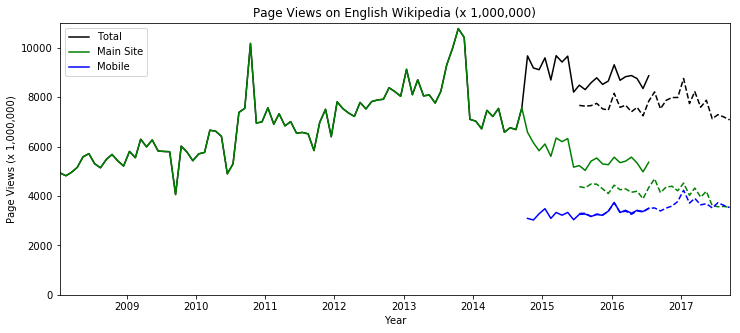

In [25]:
# Create PyPlot figure. 
plt.figure()

# Create Line2D objects to be used within the legend for each data type
total_line = mlines.Line2D([], [], color='black', linestyle="-")
main_line = mlines.Line2D([], [], color='green', linestyle="-")
mobile_line = mlines.Line2D([], [], color='blue', linestyle="-")

# Create the initial plot
ax = df.plot(x=["Date"],
             y=["pagecount_all_views", "pagecount_desktop_views", "pagecount_mobile_views",
                "pageview_all_views", "pageview_desktop_views", "pageview_mobile_views"],
             # Create a Line chart
             kind="line",
             # Scale the chart to be 12x5
             figsize=(12,5),
             # Set the title
             title="Page Views on English Wikipedia (x 1,000,000)",
             # Set the style of each line in the order the data is listed for y
             # For example "k-" means a solid black line while "b--" means a dashed blue line
             style=["k-", "g-", "b-", "k--", "g--", "b--"],
             # Disable the default legend
             legend=False)

# Set axis labels
ax.set_xlabel("Year")
ax.set_ylabel("Page Views (x 1,000,000)")

# Set y-axis scale
ax.set_ybound(0, 11000)

# Add a legend 
ax.legend([total_line, main_line, mobile_line], ["Total", "Main Site", "Mobile"], loc=2)

# If the folder outputs doesn't already exist, create it
if not os.path.exists("outputs"):
    os.makedirs("./outputs")

# Save the figure out into the outputs folder
plt.savefig("./outputs/en-wikipedia_traffic_200801-201709.png")

# Display the plot in-line
plt.show()